In [26]:
from fastai.vision.all import *
from models.swin_transformer_v2 import SwinTransformerV2
from fastai.layers import *
import torch
import models
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import PIL

In [27]:
defaults.device = torch.device('cuda')

In [28]:
def label_func(x):
    return x.parent.name

In [29]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

In [30]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, int(same))
    
    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = label_func(f)
        prod = f.name.split("_")[0]
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        prod_constrained_files = [file for file in self.splbl2files[split][cls] if file.name.split("_")[0] == prod]
        return random.choice(prod_constrained_files),same

In [31]:
class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

In [32]:
path = Path("/home/ubuntu/data/mvtec_classification/")

In [33]:
images = get_image_files(path)
labels = list(set(images.map(label_func)))
len(labels)

2

In [34]:
labels

['defective', 'good']

In [35]:
t = []

t.append(transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC))
t.append(transforms.ToTensor())
t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
data_transforms = transforms.Compose(t)

In [36]:
splits = GrandparentSplitter(train_name="train", valid_name="test")(images)
tfm = SiameseTransform(images, splits)
tls = TfmdLists(images, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize((256, 256)), ToTensor], 
                        batch_size = 16,
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [37]:
@typedispatch
def show_batch(x: SiameseImage, y, samples, 
               ctxs = None, max_n = 6, 
               nrows = None, ncols = 2, 
               figsize = None, **kwargs):
    if figsize is None: 
        figsize = (ncols * 6, max_n // ncols * 3)
    if ctxs is None: 
        ctxs = get_grid(
            min(x[0].shape[0], max_n), 
            nrows = None, ncols = ncols, 
            figsize = figsize
        )
    for i,ctx in enumerate(ctxs): 
        SiameseImage(x[0][i], x[1][i], int(x[2][i])).show(ctx=ctx)

In [38]:
# dls.show_batch()

In [39]:
swin_model = SwinTransformerV2(
    img_size=256,
    patch_size=4,
    in_chans=3,
    num_classes=1000,
    embed_dim=96,
    depths=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    window_size=8,
    mlp_ratio=4.0,
    qkv_bias=True,
    drop_rate=0.0,
    drop_path_rate=0.2,
    ape=False,
    patch_norm=True,
    use_checkpoint=True,
    pretrained_window_sizes=[0, 0, 0, 0],
    no_head=True,
)

In [40]:
swin_model.load_state_dict(torch.load('/home/ubuntu/deployment/ckpt_swin_t.pth')['model'])

<All keys matched successfully>

In [41]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)
    
    def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
        res = self.predict(item, rm_type_tfms=None, with_input=False)
        if res[0] == tensor(0):
            SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
        else:
            SiameseImage(item[0], item[1], 'Prediction: Similar').show()
        return res

In [42]:
encoder = swin_model

In [43]:
class Head(nn.Module):
    def __init__(self, bn_num=3072):
        super(Head, self).__init__()
        self.flatten = nn.Flatten()
        self.bn1 = torch.nn.BatchNorm1d(bn_num, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dropout1 = torch.nn.Dropout(p=0.5, inplace=False)
        self.linear1 = torch.nn.Linear(in_features=bn_num, out_features=512, bias=True)
        self.relu = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dropout2 = torch.nn.Dropout(p=0.5, inplace=False)
        self.linear2 = torch.nn.Linear(in_features=512, out_features=2, bias=True)
        

    def forward(self, x):
        x = self.flatten(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.linear2(x)
        return x

In [44]:
head = Head(bn_num=2000)
model = SiameseModel(encoder, head)

In [45]:
# model = model.to('cuda')

In [46]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [47]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [48]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=accuracy)

In [49]:
learn.freeze()

SuggestedLRs(valley=0.0010000000474974513)

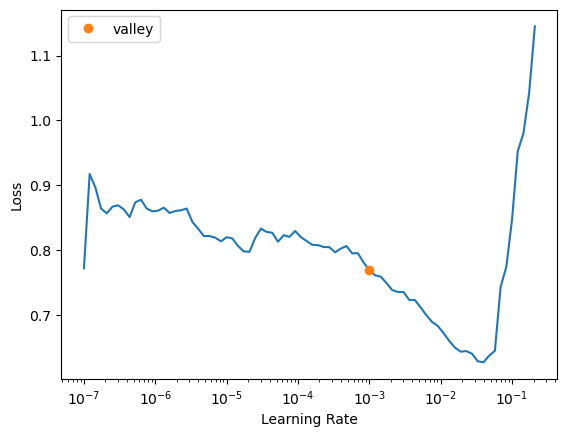

In [50]:
learn.lr_find()

In [51]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.382713,0.085077,0.975892,01:44
1,0.180591,0.059945,0.977821,01:42
2,0.164309,0.069546,0.977821,01:42
3,0.118710,0.073574,0.977821,01:43
4,0.107147,0.069584,0.979749,01:43
5,0.076468,0.064469,0.980714,01:44
6,0.090470,0.072659,0.980714,01:43
7,0.058730,0.070385,0.980714,01:43
8,0.085672,0.063459,0.981678,01:43
9,0.059366,0.073161,0.980714,01:43


In [52]:
#save model
learn.save('siamese_swin_tiny')

Path('models/siamese_swin_tiny.pth')